# CNN from Scratch
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ritchieng/deep-learning-wizard/blob/master/docs/deep_learning/fromscratch/fromscratch_cnn.ipynb)

This is an implementation of a simple CNN (one convolutional function, one non-linear function, one max pooling function, one affine function and one softargmax function) for a 10-class MNIST classification task.

## Data Pull

### Imports

In [1]:
from sklearn.datasets import fetch_openml
from sklearn.utils import check_random_state
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
%matplotlib inline

### Load Data

In [2]:
# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

In [3]:
### Plot Single Sample

X shape: (70000, 784)
y shape: (70000,)
Single sample shape: (28, 28)


<Figure size 432x288 with 0 Axes>

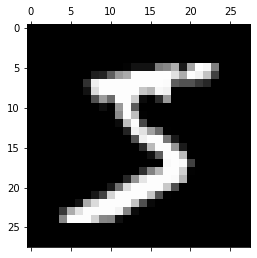

In [4]:
# Print dataset
print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')

# Print size of resized single sample
single_sample = X[0, :].reshape(28, 28)
print(f'Single sample shape: {single_sample.shape}')

# Plot single sample (M x N matrix)
plt.gray()
plt.matshow(single_sample)
plt.show()

### Train-Test Data Split

In [5]:
# Train-test split
train_samples = 60000
random_state = check_random_state(0)
permutation = random_state.permutation(X.shape[0])
X = X[permutation]
y = y[permutation]
X = X.reshape((X.shape[0], -1))

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_samples, test_size=10000)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Print shapes
print(f'Training shape {X_train.shape}')
print(f'Testing shape {X_test.shape}')

Training shape (60000, 784)
Testing shape (10000, 784)


## Forwardpropagation

### Convolutional Layer

In [6]:
class ConvolutionalLayer:
    def __init__(self, num_kernels, kernel_shape):
        # Number of kernels: 1D
        self.num_kernels = num_kernels
        # Shape of kernels: 2D
        self.kernel_shape = kernel_shape
        self.k = self.kernel_shape[0]
        # Kernel weights: 3D
        self.kernels_theta = torch.randn(self.num_kernels, self.kernel_shape[0], self.kernel_shape[1])

    def slider(self, inp):
        '''
        Sliding generator that yields square areas of shape
        (kernel_shape, kernel_shape) sliding across our input. 
        This assumes valid padding (no padding) and step size 1.
        '''
        h, w = inp.shape
        for h_idx in range(h - (self.k - 1)):
            for w_idx in range(w - (self.k - 1)):
                single_slide_area = inp[h_idx:(h_idx + self.k), w_idx:(w_idx + self.k)]
                yield single_slide_area, h_idx,w_idx

    def forward(self, inp):
        '''
        Slides kernel across image doing an element-wise MM then summing.
        Results in forward pass of convolutional layer of shape
        (output shape, output shape, number of kernels).
        '''
        # Input: 2D of (height, width)
        assert single_sample.dim() == 2, f'Input not 2D, given {single_sample.dim()}D'

        # Output via Valid Padding (No Padding): 3D of (height, width, number of kernels)
        _, w  = inp.shape
        # P = 0
        p = 0
        # O = ((W - K + 2P) / S) + 1 = (28 - 3 + 0) + 1 = 25
        o = (w - self.k) + 1
        # Print shapes
        print('Padding shape: \t', p)
        print('Output shape: \t', o)
        # Initialize blank tensor
        output = torch.zeros((o, o, self.num_kernels))
        
        # Iterate through region
        for single_slide_area, h_idx, w_idx in self.slider(inp):
            if h_idx == 0 and w_idx == 0:
                print('Region shape: \t', list(single_slide_area.shape))
                print('Kernel shape: \t', list(self.kernels_theta.shape))
                print('Single Slide: \t', list(output[h_idx, w_idx].shape))
                
            # Sum values with each element-wise matrix multiplication across each kernel
            # Instead of doing another loop of each kernel, you simply just do a element-wise MM
            # of the single slide area with all the kernels yield, then summing the patch
            output[h_idx, w_idx] = torch.sum(single_slide_area * self.kernels_theta, axis=(1, 2))
            
        # Pass through non-linearity (sigmoid): 1 / 1 + exp(-output)
        output = 1. / (1. + torch.exp(-output))

        return output
    
# Convert numpy array to torch tensor
single_sample = X[0, :].reshape(28, 28)
single_sample = torch.tensor(single_sample)

print('='*50)
print(f'Input shape: \t {list(single_sample.shape)}')
print('='*50)

# Forward: conv
conv = ConvolutionalLayer(num_kernels=8, kernel_shape=[5, 5])
output = conv.forward(single_sample)

print('='*50)
print(f'Conv (f) shape: \t {list(output.shape)}')
print('='*50)

Input shape: 	 [28, 28]
Padding shape: 	 0
Output shape: 	 24
Region shape: 	 [5, 5]
Kernel shape: 	 [8, 5, 5]
Single Slide: 	 [8]
Conv (f) shape: 	 [24, 24, 8]


### Max Pooling Layer

In [7]:
class MaxPoolLayer:
    # O = ((W - K) / S) + 1
    def __init__(self, pooling_kernel_shape):
        # Assume simplicity of K = S then O = W / S
        self.k = pooling_kernel_shape
        
    def slider(self, inp):
        '''
        Sliding generator that yields areas for max pooling.
        '''
        h, w, _ = inp.shape
        output_size = int(w / self.k)  # Assume S = K

        for h_idx in range(output_size):
            for w_idx in range(output_size):
                single_slide_area = inp[h_idx * self.k:h_idx * self.k + self.k,
                                        w_idx * self.k:w_idx * self.k + self.k]
                yield single_slide_area, h_idx, w_idx

    def forward(self, inp):
        '''
        Performs a forward pass of the maxpool layer using the given input.
        Returns a 3d numpy array with dimensions (h / 2, w / 2, num_filters).
        - input is a 3d numpy array with dimensions (h, w, num_filters)
        '''
        self.last_input = inp

        h, w, num_kernels = inp.shape
        output_size = int(w / self.k)  # Assume S = K
        output = torch.zeros(output_size, output_size, num_kernels)

        for single_slide_area, h_idx, w_idx in self.slider(inp):
            single_slide_area = torch.flatten(single_slide_area, start_dim=0, end_dim=1)
            output[h_idx, w_idx] = torch.max(single_slide_area, dim=0).values

        return output
    
print('='*50)
print(f'Input shape: \t {list(output.shape)}')
print('='*50)

# Forward: pool
pool = MaxPoolLayer(pooling_kernel_shape=2)
output = pool.forward(output)

print('='*50)
print(f'Pool (f) shape: \t {list(output.shape)}')
print('='*50)

Input shape: 	 [24, 24, 8]
Pool (f) shape: 	 [12, 12, 8]


### Affine and Soft(arg)max Layer

In [8]:
class AffineAndSoftmaxLayer:
    def __init__(self, affine_weight_shape):
        self.affine_weight_shape = affine_weight_shape
        # Weight shape: flattened input x output shape
        self.w = torch.zeros(self.affine_weight_shape[0] * self.affine_weight_shape[1] * self.affine_weight_shape[2], self.affine_weight_shape[3])
        self.b = torch.zeros(self.affine_weight_shape[3])
        
        # Initialize weight/bias via Lecun initialization of 1 / N standard deviation
        # Refer to DLW guide on weight initialization mathematical derivation:
        # https://www.deeplearningwizard.com/deep_learning/boosting_models_pytorch/weight_initialization_activation_functions/
        print(f'Lecun initialization SD: {1/self.affine_weight_shape[3]}')
        self.w = torch.nn.init.normal_(self.w, mean=0, std=1/self.affine_weight_shape[3])
        self.b = torch.nn.init.normal_(self.b, mean=0, std=1/self.affine_weight_shape[3])

    def forward(self, inp):
        '''
        Performs Linear (Affine) Function & Soft(arg)max Function
        that returns our vector (1D) of probabilities.
        '''
        inp = inp.reshape(1, -1)
        print(f'input shape: \t {inp.shape}')
        print(f'weight shape: \t {self.w.shape}')
        print(f'bias shape: \t {self.b.shape}')
        logits = torch.mm(inp, self.w) + self.b
        probas = torch.exp(logits) / torch.sum(torch.exp(logits))
        return probas
    

print('='*50)
print(f'Input shape: \t {list(output.shape)}')
print('='*50)

# Forward: Affine and Softmax
affinesoftmax = AffineAndSoftmaxLayer(affine_weight_shape=(output.shape[0], output.shape[1], output.shape[2], len(np.unique(y_train))))
output = affinesoftmax.forward(output)

print('='*50)
print(f'Affine & Soft(arg)max (f) shape: \t {list(output.shape)}')
print('='*50)

print(f'Probas: {pd.DataFrame(output.numpy()).to_string(index=False, header=False)}')

Input shape: 	 [12, 12, 8]
Lecun initialization SD: 0.1
input shape: 	 torch.Size([1, 1152])
weight shape: 	 torch.Size([1152, 10])
bias shape: 	 torch.Size([10])
Affine & Soft(arg)max (f) shape: 	 [1, 10]
Probas:  0.72574  0.001391  0.000083  0.202983  0.000503  0.037023  0.000428  0.000144  0.031293  0.000412


!!! note "Dot Product, Matrix Multiplication, and Hadamard Product"
    **Hadamard product**: element-wise multiplicaton of 2 matrices.
    </br>**Matrix Multiplication**: take the first row of the first matrix and perform dot product with each of the N columns in the second matrix to form N columns in the first row of the new matrix. Repeat for remaining rows for the first matrix.    

In [9]:
# Backward & GD: linear + softmax

# Backward & GD: pool

# Backward & GD: conv

## Note on Contiguous vs Non-Contiguous
- Often in the space of passing tensors, and doing all our dot products, hadamard products, matrix multiplications, transpose, reshape operations and more, you would inevitably one day encounter into an error that says your tensor is `not contiguous`. 
- This is a memory allocation problem. 
- Certain tensor operations like `transpose, view, expand, narrow etc` do not change the original tensor, instead they modify the properties of the tensor. 
    - For example, `transpose`, demonstrated here, would change the shape (index), but both the old and modified property tensor share the same memory block with different indexes/addresses.
    - This is why it's non-contiguous and we need to make it contiguous for some operations and typically for efficiency purpose.
- This is not a blanket statement, but you typically want your tensors to be contiguous as it prevents additional overhead incurred from translating addresses.
    - Whenever there's a warning that prompts you the tensor is not contiguous, just call `.contiguous()` and you typically should be good to go.

### Contiguous 10 by 5 tensor

In [10]:
contiguous_tensor = torch.arange(50).view(10, 5)
print(contiguous_tensor.shape)
# Pretty print quick hack via Pandas DataFrame
print(pd.DataFrame(contiguous_tensor.numpy()).to_string(index=False, header=False))

torch.Size([10, 5])
  0   1   2   3   4
  5   6   7   8   9
 10  11  12  13  14
 15  16  17  18  19
 20  21  22  23  24
 25  26  27  28  29
 30  31  32  33  34
 35  36  37  38  39
 40  41  42  43  44
 45  46  47  48  49


### Stride 5 by 1
- Stride here shows how we need:
    - 5 steps to move one row to the next &
    - 1 step to move from one column to the next (contiguous)
        - If this becomes anything other than 1 step, it becomes not contiguous

In [11]:
print(contiguous_tensor.stride())
print(contiguous_tensor.is_contiguous())

(5, 1)
True


### Non-contiguous Tensor via Transpose Operation
- In order to access the next "column" value of 5, we have to take 5 steps despite the transpose as if we would do in our original tensor
- Because the original tensor and this transposed tensor share the same memory block!

In [12]:
non_contiguous_tensor = contiguous_tensor.t()
print(non_contiguous_tensor.shape)
print(pd.DataFrame(non_contiguous_tensor.numpy()).to_string(index=False, header=False))

torch.Size([5, 10])
 0  5  10  15  20  25  30  35  40  45
 1  6  11  16  21  26  31  36  41  46
 2  7  12  17  22  27  32  37  42  47
 3  8  13  18  23  28  33  38  43  48
 4  9  14  19  24  29  34  39  44  49


### Stride 1 by 5

In [13]:
print(non_contiguous_tensor.stride())
print(non_contiguous_tensor.is_contiguous())

(1, 5)
False


### Convert to Contiguous

In [14]:
# Convert to contiguous
convert_contiguous = non_contiguous_tensor.contiguous()
print(convert_contiguous.is_contiguous())

True
